# PROJECT II: CONVOLUTION, CROSS- CORRELATION AND IMAGE PANORAMAS

    Exercise: Convolution:
    
    • Denoise the image with a Gaussian filter. You may use the code from the in class demo to create the
    • Gaussian filter, but you must use your own implementation of convolution.
    • Compute derivative images (with respect to x and with respect to y) using the separable derivative filter of your choice, e.g. [-1 0 1] and [-1 0 1]T . You can hardcode the derivative filter, but use your implementation of convolution.
    • Compute the gradient magnitude image.
    • Create binary edge images from the gradient magnitude image using several thresholds
    
    Exercise: Cross Correlation:
    
    • Threshold the original key image so that the background is [0.0] and keys appear as [1.0]. You should have a binary image with only [0.0] (background) and [1.0] (keys).
    • Choose your favorite key and crop with a narrow boundary. Use this image as your template.
    • Modify your template by setting background pixels to [-1.0], so that you have [+1.0] for the key and [-1.0] for background. The reason for creating a signed template is improved matching performance.
    • Implement cross-correlation with the binary input image and your new signed template image.
    • Please recall that this results in a peak (maximum) if the template matches the specific image region which you selected for your template.
    • Do a pass through the correlation image to detect the maximum peak value and its (x,y) location. You may mark this location with an overlay of a circle or just manually painting an arrow or similar. Discuss if this location matches your expectation. Discuss the appearance and cause of other local peaks, and how they compare to the global peak.
    
    Exercise: Image Panorama

    •Take two photos which overlap and differ only in rotation, e.g. similar to the example images above.
    • Implement an image panorama for the case of 2 images (a source and a target). The algorithm is:
    • Define corresponding points between the two images (these are pixel coordinates which you can find by hovering your mouse in a paint program, or found in any manner of your choice).
    • Using the corresponding points, construct the known matrix and vector shown above. Note that this is similar to our affine example but with a different matrix structure.
    • Solve for parameters P with linear least squares (e.g. use np.linalg.lstsq or similar).
    • Using the found parameters P, transform the target image. You must implement the transformation yourself, but you may use any code from the demos. You can use any interpolation of your choice.
    • Combine the source and transformed target together on the same canvas. You can handle the area of overlap in anyway you choose (simplest is to always overwrite the grey values in the canvas image). Don’t worry if your panorama has an obvious seam.
    • Compare results using 4, 5, 6, and 7 corresponding points.

In [437]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage import io
from skimage.color import rgb2gray
import matplotlib.patches as patches

In [438]:
def importImage(path):
    #status:complete
    #task: imports image, converts it into grayscale and returns image, #rows, #cols
    #parameter: path
    #returns: grayscaled image
    
    im = io.imread(path)
    im = rgb2gray(im)
    im = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) *1.0)).astype('float')
    return im

In [439]:
def createGaussianFilter(n, stdev):
    #status: complete   
    #task: creates a square gaussian filter
    #parameters: n= rows and column count, stdev= standard deviation
    #returns: gaussian kernel of size (n,n) and standard dev of stdev
    
    variance=stdev*stdev #variance
    gaussian_filter=np.zeros((n, n))
    x=np.linspace(-n/2.0, n/2.0, n)
    y=np.linspace(-n/2.0, n/2.0, n)
    
    for i in range(0, n):
        for j in range(0, n):
            gaussian_filter[i, j]=(1/math.sqrt((2*math.pi*variance)))*math.exp(-(x[i]*x[i]+y[j]*y[j])/(2*variance))
    return gaussian_filter/np.sum(gaussian_filter.flatten())

In [440]:
def adjustInputs(image, Mask, opType):
    #status: complete
    #task: adjust inputs by padding
    #parameters: image, Mask=kernel, opType= True if Convolution False if CrossCorrelation
    #returns: x pad size, y pad size, Mask
    #output_size= (input_size- filter_size + 2*Padding_size)+1
    #if input and output size are same: then Padding_size=(filter_size-1)/2 (ceil it)
      
    (init_x_size, init_y_size)=image.shape
    if(opType==True):
        Mask=np.flipud(np.fliplr(Mask))
  
    x_pad_size=math.ceil((Mask.shape[0]-1)/2)
    y_pad_size=math.ceil((Mask.shape[1]-1)/2)
    pad_sizes=[x_pad_size, y_pad_size]    
    image=np.pad(image, (max(pad_sizes)), mode='constant')

    return x_pad_size, y_pad_size, image, Mask, max(pad_sizes)

In [441]:
def FindDerivativeImages(image, xDerivativeMask, yDerivativeMask, thresholds):
    #status: complete
    #task: finds x and y derivatives, magnitude of the derivatives of the image
    #parameters: image, xDerivative, yDerivative
    #returns: xgradient, ygradient, magnitude
    
    init_x_size, init_y_size=image.shape
    
    x_pad, y_pad, ximage, xDerivativeMask, max_pad=adjustInputs(image, xDerivativeMask, True)
    xgrad_output_image = CommonUtil(ximage, init_x_size, init_y_size, max_pad, x_pad, y_pad, xDerivativeMask, True)

    x_pad, y_pad, yimage, yDerivativeMask, max_pad=adjustInputs(image, yDerivativeMask, True)
    ygrad_output_image = CommonUtil(yimage, init_x_size, init_y_size, max_pad, x_pad, y_pad, yDerivativeMask, True)

    joined_filter=np.multiply(xDerivativeMask, yDerivativeMask)
    grad_output_image = CommonUtil(yimage, init_x_size, init_y_size, max_pad, x_pad, y_pad, yDerivativeMask, True)
    
    magnitude=findMagnitude(xgrad_output_image, ygrad_output_image, [], False)
    magnitudes_by_thresholds=findMagnitude(xgrad_output_image, ygrad_output_image, thresholds, True)

    return xgrad_output_image, ygrad_output_image, magnitude, magnitudes_by_thresholds

In [442]:
def CommonUtil(image, init_x_size, init_y_size, max_pad, x_pad, y_pad, Mask, isGrad):
    #status: complete
    #task: utility function to multiply kernel to image patch
    #output: adjusted image
    
    if(isGrad):
        grad_output_image= np.zeros((init_x_size+2*y_pad, init_y_size+2*x_pad))
    else:
        grad_output_image= np.zeros((init_x_size, init_y_size))

    out_row=0
    out_col=0
    
    for x_pivot in range(x_pad, init_x_size+x_pad):
        out_col=0
        for y_pivot in range(y_pad, init_y_size+y_pad):
            patch=image[x_pivot-max_pad: x_pivot+max_pad+1, y_pivot-max_pad: y_pivot+max_pad+1]            
            grad_output_image[out_row][out_col] = np.sum(np.multiply(Mask, patch))
            out_col+=1
        out_row+=1
    return grad_output_image

In [443]:
def Convolve(image, Mask, opType):
    #status: complete
    #task: perform Convolution or CrossCorrelation 
    #parameters: image, Mask=kernel, opType= True if Convolution False if CrossCorrelation
    #returns: convolved image
    
    (init_x_size, init_y_size)=image.shape
    x_pad, y_pad, image, Mask, max_pad=adjustInputs(image, Mask, True)   
    output_image= CommonUtil(image, init_x_size, init_y_size, max_pad, x_pad, y_pad, Mask, False)
    return output_image

In [444]:
def findMagnitude(xGrad, yGrad, thresholds, useThresholds):
    #status: complete
    #params: xGrad, yGrad  
    #returns: magnitude using the x and y gradients
    
    if(useThresholds):
        magnitudes=[]
        for i in range(len(thresholds)):
            magnitudes.append(np.zeros(xGrad.shape, np.float32))
                
        x_len=xGrad.shape[1]
        y_len=yGrad.shape[0]

        thresCount=0
        for mag in magnitudes:
            for i in range(x_len):
                for j in range(y_len):
                    temp=np.sqrt(xGrad[i][j]**2 + yGrad[i][j]**2)%255
                    if(temp>=thresholds[thresCount]):
                        mag[i][j]=255
                    else:
                        mag[i][j]=0
            thresCount+=1                    
        return magnitudes
    
    else:        
        mags=np.zeros(xGrad.shape, np.float32)
        x_len=xGrad.shape[1]
        y_len=yGrad.shape[0]
        for i in range(x_len):
            for j in range(y_len):
                mags[i][j]=np.sqrt(xGrad[i][j]**2 + yGrad[i][j]**2)%255
        return mags

In [445]:
def correlate(image, template):
    #status: complete
    #params: image, template  
    #returns: correlated image
   
    (init_x_size, init_y_size)=image.shape    
    x_pad, y_pad, image, Mask, max_pad=adjustInputs(image, template, True)
    
    grad_output_image=np.zeros((image.shape))    
    x, y=(0, 0) 
    maxim=-1000
    for x_pivot in range(0, image.shape[0]-Mask.shape[0]):
        for y_pivot in range(0, image.shape[1]-Mask.shape[1]):
            patch=image[x_pivot: x_pivot+Mask.shape[0], y_pivot: y_pivot+Mask.shape[1]]
            temp=np.sum(np.multiply(patch, Mask))
            if(maxim<=temp):
                maxim=temp
                x, y=(x_pivot+(Mask.shape[0])//2, y_pivot+Mask.shape[1]//2)

            grad_output_image[x_pivot+(Mask.shape[0])//2][y_pivot+Mask.shape[1]//2] = temp
    return grad_output_image, x, y, image

In [446]:
def displayCorner(nRows, nCols, imgArray, nameArray):
    #status: complete
    #params: nrows, ncols, images array, names of the images,  
    #returns: subplots of given format
    
    c = 1  # initialize plot counter
    fig = plt.figure(figsize=(14,10))
    for i in imgArray:
        plt.subplot(nRows, nCols, c)
        plt.title(nameArray[c-1])
        plt.imshow(imgArray[c-1], cmap='gray')
        c = c + 1
    plt.show()

In [447]:
def binarize(image, isTemplate):       
    #status: complete
    #task: Convert image to binary image using the threshold of 200
    #params: image, isTemplate: if it is template or not (in case of cross correlation)
    #output: binarized image
    
    image=image*255
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if(image[i][j]<200):
                image[i][j]=1
            else:
                if(isTemplate):
                    image[i][j]=-1
                else:
                    image[i][j]=0
    return image

In [448]:
def CreateAffine(L_arr, R_arr, features):
    #status: complete
    #Task: create affine transformation matrix using the fetaures arrays (co-ordinates of left and right image)
    #parameters: Left image co-ordinates, Right image co-ordinates, features
    #return Transformation matrix, inverse transformation matrix
    row=0
    col=0
    X=[]
    for i in range(features):
        temp=[-(L_arr[i][0]), -(L_arr[i][1]), -1, 0, 0, 0, (L_arr[i][0])*(R_arr[i][0]), (L_arr[i][1])*(R_arr[i][0])]
        X.append(temp)
    for i in range(features):
        temp=[0, 0, 0, -(L_arr[i][0]), -(L_arr[i][1]), -1, (L_arr[i][0])*(R_arr[i][1]), (L_arr[i][1])*(R_arr[i][1])]
        X.append(temp)
    X=np.array(X)
    
    XDash=[]
    for i in range(features):
        XDash.append(R_arr[i][0])
    for i in range(features):
        XDash.append(R_arr[i][1])
    XDash=np.array(XDash)
    
    params=np.linalg.lstsq(X, XDash)[0]
    params=np.append(params, 1)
    T=params.reshape(3, 3)
    Tinv = np.linalg.inv(T)
    
    return T, Tinv

In [449]:
def adjustments(im1, T):
    rows, cols=(im1.shape)
    # Top left corner
    top_left = T.dot(np.array([0.0, 0.0, 1.0], float))
    top_left = top_left // top_left[2]
  
    # Bottom left corner
    bottom_left = T.dot(np.array([rows-1.0, 0.0, 1.0], float))
    bottom_left = bottom_left // bottom_left[2]
  
    # Top right corner
    top_right = T.dot(np.array([0.0, cols-1.0, 1.0], float))
    top_right = top_right // top_right[2]
  
    # Bottom right corner
    bottom_right = T.dot(np.array([rows-1.0, cols-1.0, 1.0], float))
    bottom_right = bottom_right // bottom_right[2]

    # Calculate tight bounding box around the transformed corners
    min_rows = np.min([top_left[0], bottom_left[0], top_right[0], bottom_right[0]])
    max_rows = np.max([top_left[0], bottom_left[0], top_right[0], bottom_right[0]])

    min_cols = np.min([top_left[1], bottom_left[1], top_right[1], bottom_right[1]])
    max_cols = np.max([top_left[1], bottom_left[1], top_right[1], bottom_right[1]])

    out_sampling_rows = np.linspace(math.floor(min_rows), math.ceil(max_rows), math.ceil(max_rows) - math.floor(min_rows)+1)
    out_sampling_cols = np.linspace(math.floor(min_cols), math.ceil(max_cols), math.ceil(max_cols) - math.floor(min_cols)+1)
    
    return min_rows, max_rows, min_cols, max_cols, out_sampling_cols, out_sampling_rows

In [450]:
def Panorama(im1, im2, Tinv, min_rows, max_rows, min_cols, max_cols, out_sampling_cols, out_sampling_rows):
    #status: Complete
    #
    rows, cols=(im1.shape[0], im1.shape[1])
    out_im2 = np.zeros((len(out_sampling_rows), im2.shape[1]+im1.shape[1]))

    im1=np.flipud(np.fliplr(im1))

    c_1=out_sampling_cols.shape[0]
    r_1=out_sampling_rows.shape[0]
    for cur_row in range(0, len(out_sampling_rows)):
        for cur_col in range(0, len(out_sampling_cols)):
            cur_pt = np.array([out_sampling_rows[cur_row], out_sampling_cols[cur_col], 1.0])
            transformed_pt = Tinv.dot(cur_pt)
            transformed_pt = transformed_pt / transformed_pt[2]
            if (np.floor(transformed_pt[0]) < 0 or np.ceil(transformed_pt[0]) >= rows or \
                np.floor(transformed_pt[1]) < 0 or np.ceil(transformed_pt[1]) >= cols):
                continue
            new_row = int(round(transformed_pt[0]))
            new_col = int(round(transformed_pt[1]))
            out_im2[cur_row, cur_col] = im1[new_row, new_col]
            c_1-=1
        r_1-=1

    start_row=im2.shape[0]
    start_col=im2.shape[1]
    c_1, r_1=(0, 0)
    rows, cols=(out_im2.shape[0], out_im2.shape[1])

    dif_cols=out_sampling_cols.shape[0]-im1.shape[1]
    dif_rows=out_sampling_rows.shape[0]-im1.shape[0]
        
    for i in range(int(round(out_im2.shape[0]-im1.shape[0])/2), dif_rows+im2.shape[0]):
        c_1=0
        for j in range(cols-start_col-dif_cols, cols-1):
            if(c_1>=im2.shape[1] or r_1>=im2.shape[0]):
                continue
            out_im2[i][j]=im2[r_1][c_1]
            c_1+=1
        r_1+=1

    return im1, im2, out_im2

In [453]:
def main(cross_corr_paths, conv_image_path, filter_size, im_path, features, n_features):
    #status: incomplete
    #params: conv_image_path= image path for convolution, filter_size= filter size
    
    #1. Convolution
    image=importImage(conv_image_path)
    gaussian_filter=createGaussianFilter(filter_size, 2) #stdev assumed 20
    Gaussian_conv=Convolve(image, gaussian_filter, True)
    y_prewitt_filter=(np.array([[-1, 0, 1]]).T)
    x_prewitt_filter=np.array([[-1, 0, 1]])
    thresholds= [1, 2, 0.5]
    xGradImage, yGradImage, magnitude, binary_mags=FindDerivativeImages(image, x_prewitt_filter, y_prewitt_filter, thresholds) 
    image_list=[image, gaussian_filter, Gaussian_conv, xGradImage, yGradImage, magnitude]
    names_list=["Image Imported", "Gaussian Filter of size: ("+str(filter_size)+" , "+str(filter_size)+")", "Output Image", "xGradient", "yGradient", "Magnitude (edges) using x and y grads"]
    displayCorner(2, 3, image_list, names_list)
    names_list=["Threshold: 1","Threshold: 2","Threshold: 0.5"]
    displayCorner(2, 3, binary_mags, names_list)
    
    
    #2. Cross Correlation
    image_corr=importImage(cross_corr_paths[0])
    image_corr=binarize(image_corr, False)
    filter_image=importImage(cross_corr_paths[1])
    filter_image=binarize(filter_image, True)
    out_image, x, y, in_image=correlate(image_corr, filter_image)
    displayCorner(2, 2, [image_corr, filter_image, in_image, out_image], ["Binarized input", "Binarized filter", "After Padding", "Correlated Output"])
    image = cv2.rectangle(out_image, (x, y), (x-2*filter_image.shape[1], y+2*filter_image.shape[0]), (255, 0, 0), 2)
    plt.imshow(image, cmap="gray")
    

    #3. Image Panorama
    im_path1 = im_path[0]
    im_path2 = im_path[1]
    im1, im2=(importImage(im_path1), importImage(im_path2))
    Left_img_features=features[0]
    Right_img_features=features[1]
    T, Tinv=CreateAffine(Left_img_features, Right_img_features, n_features)
    min_rows, max_rows, min_cols, max_cols, out_sampling_cols, out_sampling_rows= adjustments(im1, T)
    im1, im2, out_im= Panorama(im1, im2, Tinv, min_rows, max_rows, min_cols, max_cols, out_sampling_cols, out_sampling_rows)
    displayCorner(1, 2, [im1, im2], ["Right image", "Left Image"])
    plt.imshow(out_im, cmap="gray")
    plt.title("Panorama Image")

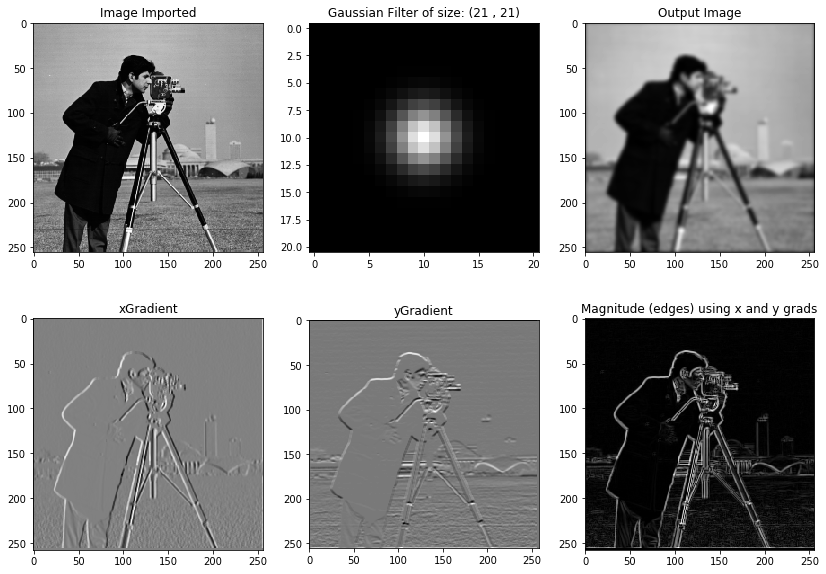

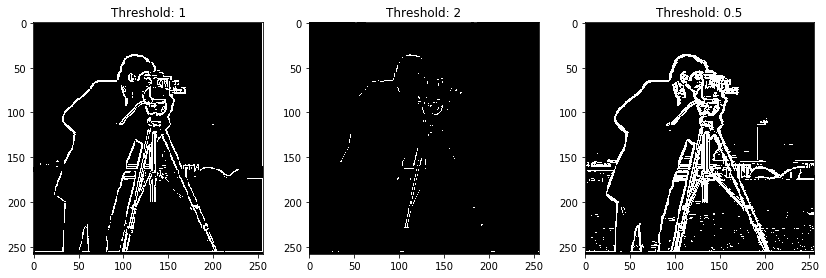

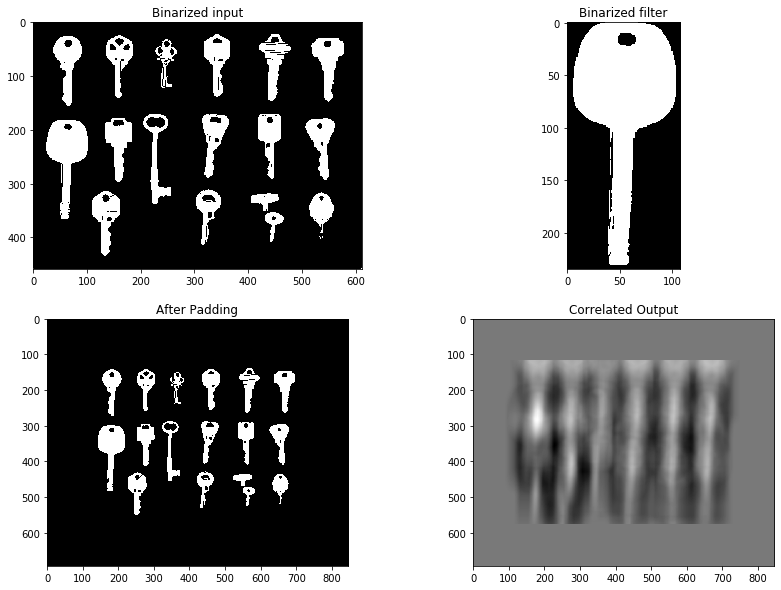

D:\anaconda\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


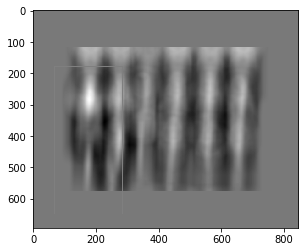

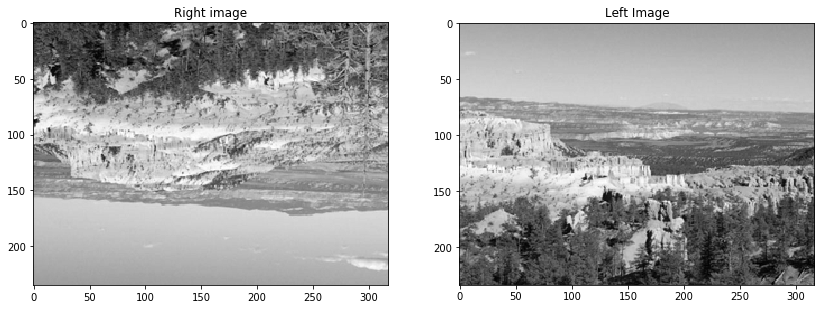

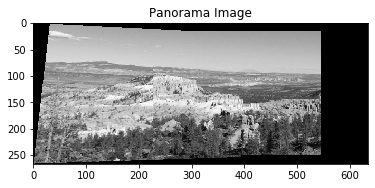

In [456]:
if __name__=="__main__":
    im_path1 = 'C:\\Users\\pruth\\Desktop\\NYU\\Year-1\\Spring\\CV\\Assignments_notebooks\\m1.png'
    im_path2 = 'C:\\Users\\pruth\\Desktop\\NYU\\Year-1\\Spring\\CV\\Assignments_notebooks\\m2.png'
    Left_img_features=[(214, 35), (297, 182), (239, 170), (284, 98), (292, 109),(286, 131), (269, 141), (318, 79), (255, 111),]
    Right_img_features=[(8, 26), (95, 175), (38, 165), (81, 90), (89, 102), (82, 124), (66, 134), (1, 68), (53, 106)] 
    n_features=4
    main(["multiplekeys.png", "key_2.png"],"cameraman.png", 21, [im_path1, im_path2], [Left_img_features, Right_img_features], n_features)